# Metadata level success analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd

# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

## Load metadata

In [3]:
metadata = pd.read_csv("metadata_merged.csv", index_col=0)

In [4]:
metadata.head()

,doi,publicationDate,publisher,subject,type,name
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
1,doi:10.7910/DVN/6KEXM7,2020,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
2,doi:10.7910/DVN/EEUTHP,2019,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
3,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
4,doi:10.7910/DVN/N0PBQ9,2015,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse


## Load success rate data

In [5]:
df = pd.read_csv("aggregate_results_env.csv", index_col=0)

In [6]:
len(df.doi.unique())

2085

In [7]:
df.head()

,doi,file,r32,r36,r40,result,success
0,doi:10.7910/DVN/XFQZI2,Condemnation.R,"Error in eval(expr, envir, enclos) : could not...",Error in read.dta13('Condemnation.dta') : co...,NaN,NaN,NaN
1,doi:10.7910/DVN/WGPDBS,Replication_of_Figures.R,success,success,success,success,1.0
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,"Error in diag(vcovHC(DMareg, type = 'HC3')) : ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...",0.0
3,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,"Error in ggsave('placebo.pdf', plot = placebo,...",success,success,success,1.0
4,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,"Error in ggsave('historical_trend.pdf', plot =...",success,success,success,1.0


Total number of entries: 3695
Total number after bad DOIs are removed: 3695
Unique DOIs: 1447
Success: 1472 out of 3695 => 0.3983761840324763
TIL: 0 out of 3695 => 0.0
Error: 2223 out of 3695 => 0.6016238159675237


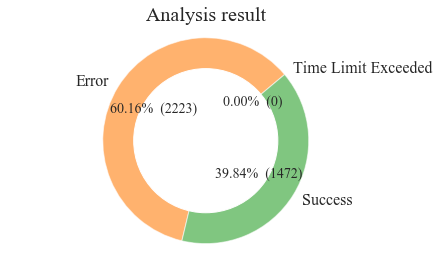

In [8]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def get_success_rates(df):
    print "Total number of entries: "+ str(len(df))
    print "Total number after bad DOIs are removed: "+ str(len(df))
    
    print "Unique DOIs: "+ str(len(df['doi'].unique()))
    
    # calculate success
    success = (df['result'] == 'success').sum()
    print "Success: " + str(success)+ " out of " + str(len(df)) +" => "+ str(success*1.0/len(df))
    
    til = (df['result'] == 'time limit exceeded').sum()
    print "TIL: " + str(til)+ " out of " + str(len(df)) +" => "+ str(til*1.0/len(df))
    
    error = len(df)-til-success
    print "Error: " + str(error)+ " out of " + str(len(df)) +" => "+ str(error*1.0/len(df))
    
    return [til, error, success]

def plot_code(df, plot_title, plot_name, aggregation=False):
    labels = ["Time Limit Exceeded",'Error', 'Success']
    if aggregation:
        sizes = get_aggregated(df)
    else:
        sizes = get_success_rates(df)
     
    fig1, ax1 = plt.subplots()
    plt.rcParams['font.size'] = 16
    ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=40,  \
            textprops={'fontsize': 14},wedgeprops={'alpha':0.6})

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.title(plot_title, size=20)
    plt.tight_layout()

    plt.show()
    #fig1.savefig("plots/{}".format(plot_name), dpi=100)
    
dfe = df[df.result.notnull()]
plot_code(dfe, "Analysis result", "fin_result2.png")

## Merge the datasets

In [9]:
total = pd.merge(df,metadata,on='doi')

In [10]:
len(total)

6832

## Merge aggrigated

In [11]:
agg = total.groupby(['doi']).success.max().reset_index()

In [12]:
agg.head()

,doi,success
0,doi:10.7910/DVN/03CDTK,NaN
1,doi:10.7910/DVN/05BSPP,0.0
2,doi:10.7910/DVN/0BFF0K,1.0
3,doi:10.7910/DVN/0BPVCH,NaN
4,doi:10.7910/DVN/0DE35E,1.0


In [13]:
len(agg)

1923

In [14]:
agg_total = pd.merge(agg, metadata, on='doi')

In [15]:
len(agg_total)

1923

In [16]:
agg_total.to_csv('agg_total.csv')

## Analysis

- Drop if NaN or TLE

In [16]:
df = total
df_temp = df.drop(df[df.result.isnull() | (df['result'] == 'time limit exceeded')].index)

In [17]:
df_temp.result.isna().sum()

0

In [18]:
total = df_temp

In [19]:
def success(el):
    if pd.isna(el):
        return el
    if el == 'success':
        return 1
    if len(str(el))>1:
        return 0
    else:
        el

total['success']=total["result"].apply(success)

In [134]:
total.to_csv('total.csv')

## Journal 

In [20]:
journals = total[total['type']=="JOURNALS"]
print("All journals' success rate: "+ str(journals.success.sum()*1./len(journals)))

All journals' success rate: 0.42024253731343286


In [21]:
def fix_name(el):
    return el.split('Dataverse')[0].strip()

def fix_name2(x):
    if 'International Interactions (II)' in x:
        return 'International Interactions (II)'
    if 'American Journal of Political Science (AJPS)' in x:
        return 'American Journal of Political\nScience (AJPS)'
    if 'British Journal of Political Science' in x:
        return 'British Journal of\nPolitical Science'
    if 'American Political Science Review' in x:
        return 'American Political\nScience Review'
    if 'Review of Economics and Statistics' in x:
        return 'Review of Economics\nand Statistics'
    if 'Political Science Research and Methods (PSRM)' in x:
        return 'Political Science Research\nand Methods (PSRM)'
    if 'Journal of Experimental Political Science' in x:
        return 'Journal of Experimental\nPolitical Science'
    if 'International Studies Quarterly' in x:
        return 'International\nStudies Quarterly'
    return x

In [22]:
journals.name = journals.name.apply(fix_name)
journals.name = journals.name.apply(fix_name2)

In [23]:
# journal policy
policy = pd.read_csv("data/journal-policy.txt", sep ='\t')
policy.name = policy.name.apply(fix_name2)
policy

,name,link,type,level
0,American Journal of Political\nScience (AJPS),https://ajps.org/ajps-verification-policy/,verification,5
1,British Journal of\nPolitical Science,https://www.cambridge.org/core/services/aop-fi...,required,3
2,American Political\nScience Review,https://www.apsanet.org/APSR-Submission-Guidel...,required,3
3,Review of Economics\nand Statistics,https://www.mitpressjournals.org/journals/rest...,required,3
4,Political Science Research\nand Methods (PSRM),https://www.cambridge.org/core/journals/politi...,verification,5
5,Journal of Experimental\nPolitical Science,https://www.cambridge.org/core/journals/journa...,required,3
6,International\nStudies Quarterly,https://academic.oup.com/isq/pages/General_Ins...,required,3
7,International Interactions (II),https://www.tandfonline.com/action/authorSubmi...,encouraged,2
8,The Journal of Politics,https://www.journals.uchicago.edu/journals/jop...,no policy,1
9,Political Analysis,https://www.cambridge.org/core/journals/politi...,reviewed,4


In [24]:
journal_policy = pd.merge(journals,policy,on='name')

In [25]:
len(journal_policy)

1971

In [26]:
#temp = temp[temp.type_y != "no policy"]

In [27]:
temp = journal_policy
temp = temp.groupby(['name','publicationDate']).agg({'success': ['sum','count']}).reset_index()
temp['s']=temp['success']['sum'] / temp['success']['count']
temp.head()

name publicationDate success  \
                                                                     sum   
0  American Journal of Political\nScience (AJPS)            2015      25   
1  American Journal of Political\nScience (AJPS)            2016      13   
2  American Journal of Political\nScience (AJPS)            2017      53   
3  American Journal of Political\nScience (AJPS)            2018      24   
4  American Journal of Political\nScience (AJPS)            2019      61   

                s  
  count            
0    30  0.833333  
1    20  0.650000  
2    67  0.791045  
3    54  0.444444  
4   103  0.592233

In [28]:
#df = temp.pivot(columns='name', index='publicationDate', values='s').reset_index()
#df.fillna(0.0, inplace=True)

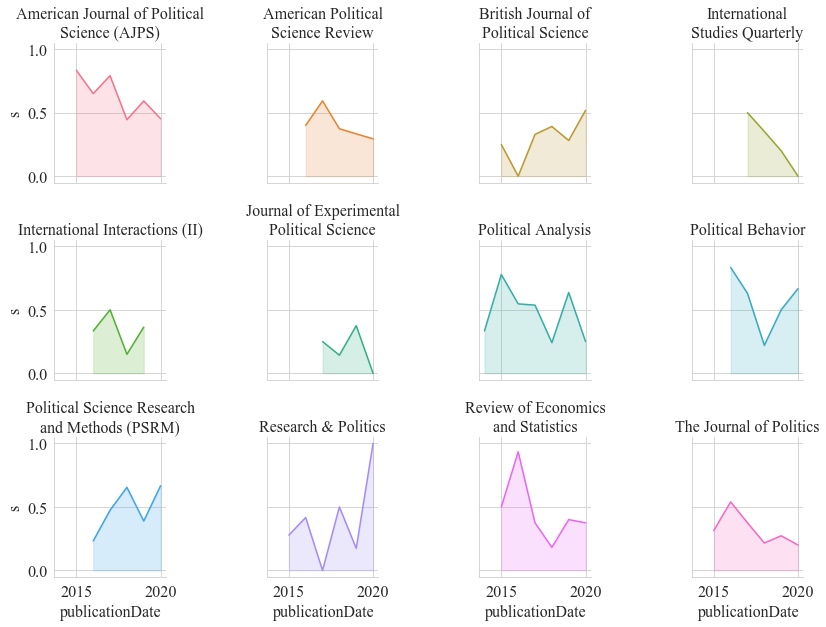

In [29]:
df= temp
g = sns.FacetGrid(df, col='name', hue='name', col_wrap=4, )
 
# Add the line over the area with the plot function
g = g.map(plt.plot, 'publicationDate', 's')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'publicationDate', 's', alpha=0.2).set_titles("{col_name}")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
#plt.subplots_adjust(top=0.92)
#g = g.fig.suptitle('Evolution of the value of stuff in 16 countries')

#fig.tight_layout()
#fig.show()

# Aggregated

In [30]:
ag_journals = agg_total[agg_total['type']=="JOURNALS"]
ag_journals = ag_journals.drop(ag_journals[ag_journals.success.isnull()].index)

ag_journals.name = ag_journals.name.apply(fix_name)
ag_journals.name = ag_journals.name.apply(fix_name2)

In [31]:
print("Aggregated all journals' success rate: "+ str(ag_journals.success.sum()/len(ag_journals)))

Aggregated all journals' success rate: 0.4729381443298969


In [32]:
ag_journal_policy = pd.merge(ag_journals,policy,on='name')

In [33]:
# temp = temp[temp.type_y != "no policy"]

In [34]:
temp = ag_journal_policy
temp = temp.groupby(['name','publicationDate','type_y']).agg({'success': ['sum','count']}).reset_index()
temp['s']=temp['success']['sum'] / temp['success']['count']

In [35]:
pal = sns.color_palette("nipy_spectral")

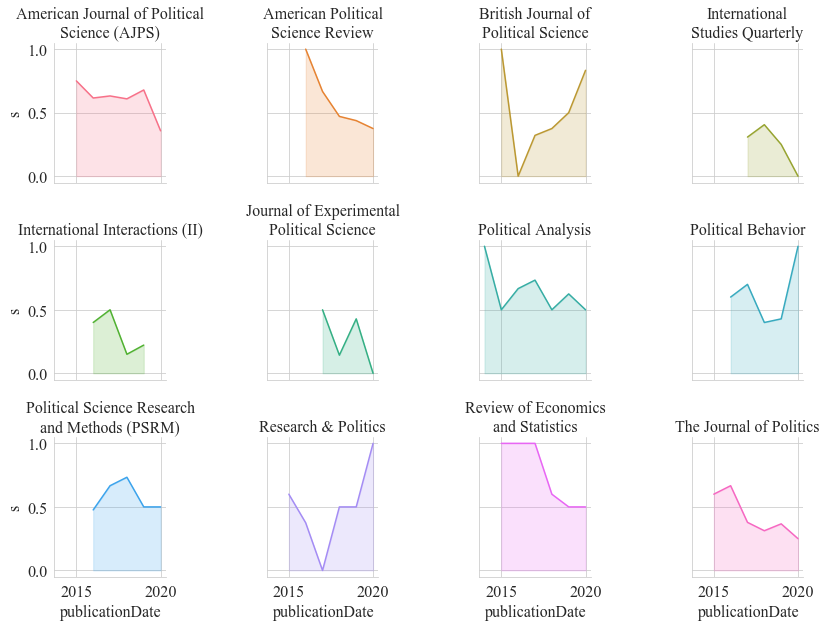

In [36]:
df= temp
g = sns.FacetGrid(df, col='name', hue='name', col_wrap=4, )
 
# Add the line over the area with the plot function
colors = {"no policy": pal[4], "encouraged": pal[3], "required": pal[2], "reviewed": pal[1], "verification": pal[0]} 
g = g.map(plt.plot, 'publicationDate', 's')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'publicationDate', 's', alpha=0.2).set_titles("{col_name}")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
#plt.subplots_adjust(top=0.92)
#g = g.fig.suptitle('Evolution of the value of stuff in 16 countries')

#fig.tight_layout()
#g.savefig("over_time.png")
#fig.show()

# Aggregated results plotted per policy type

In [37]:
temp = ag_journal_policy
temp = temp.groupby(['publicationDate','type_y']).agg({'success': ['sum','count']}).reset_index()
temp['s']=temp['success']['sum']*100. / temp['success']['count']

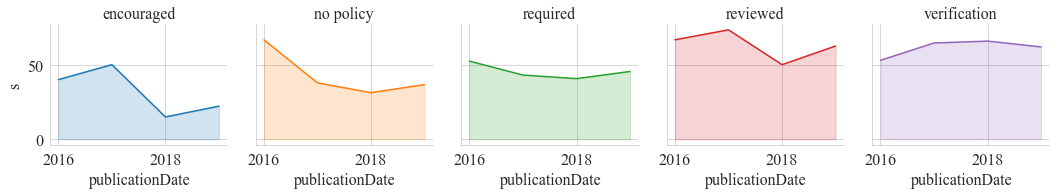

In [38]:
df= temp
#g = sns.FacetGrid(df, col='type_y', hue='type_y', col_wrap=5, )
g = sns.FacetGrid(
    df[(df['publicationDate']<2020) & (df['publicationDate']>2015)], col='type_y', hue='type_y', col_wrap=5, )


# Add the line over the area with the plot function
colors = {"no policy": pal[4], "encouraged": pal[3], "required": pal[2], "reviewed": pal[1], "verification": pal[0]} 
g = g.map(plt.plot, 'publicationDate', 's')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'publicationDate', 's', alpha=0.2).set_titles("{col_name}")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
#plt.subplots_adjust(top=0.92)
#g = g.fig.suptitle('Evolution of the value of stuff in 16 countries')

#fig.tight_layout()
#g.savefig("policy_type.png")
#plt.title("Success rate per policy type from 2016 to 2019")
#fig.show()

In [39]:
# temp.pivot(columns='success', index='name', values='publicationDate')

# Journal per year

In [42]:
journals.publisher.unique()

array(['ajps', 'BJPolS', 'jop', 'restat', 'pan', 'ipsr-risp',
       'the_review', 'LAPS', 'PSRM', 'isq', 'IOJ', 'lsq', 'xps',
       'researchandpolitics', 'world-politics', 'JPublicPolicy',
       'perspectives', 'internationalinteractions', 'culturalanalytics',
       'economics', 'polbehavior', 'FPA', 'JAERE', 'bpsr', 'ps', 'qje',
       'jhr', 'tpmnewsletter', 'palcomms', 'jlc', 'isec', 'JJPS', 'cjip'],
      dtype=object)

In [43]:
top = [
    'jop', 'ajps', 'PSRM', 'BJPolS', 'pan', 'isq','IOJ','culturalanalytics','JPublicPolicy',
    'the_review','polbehavior','restat','internationalinteractions','xps','researchandpolitics']

In [44]:
journals_subset = journals.drop(journals[~journals.publisher.isin(top)].index)

In [45]:
temp = journals_subset
temp = temp.groupby(['name','publicationDate']).agg({'success': ['sum','count']}).reset_index()
temp['s']=temp['success']['sum']*100. / temp['success']['count']

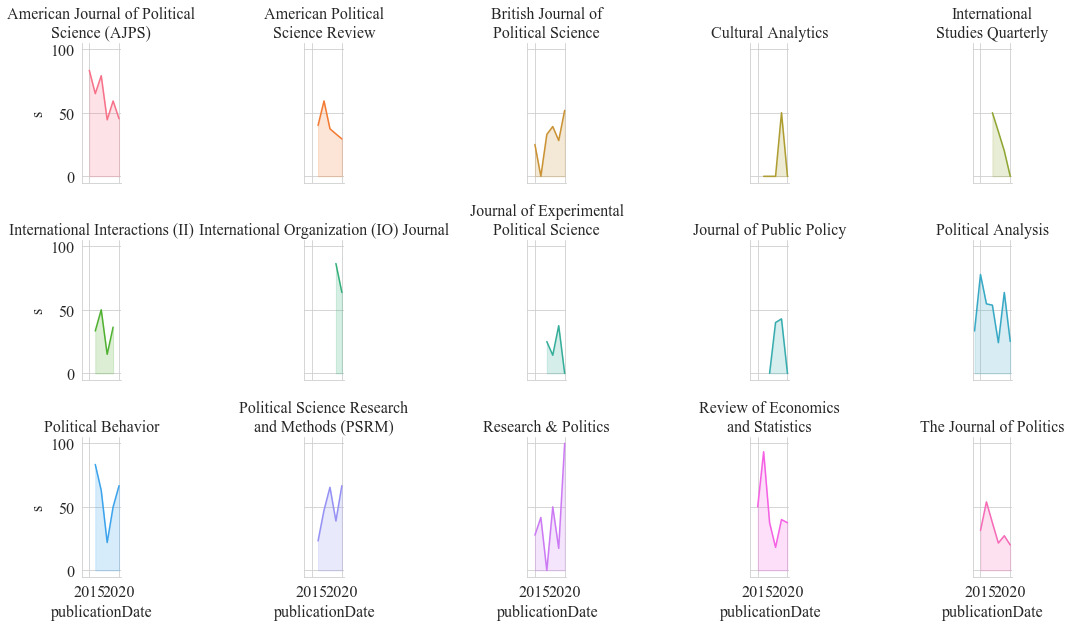

In [46]:
df= temp
g = sns.FacetGrid(df, col='name', hue='name', col_wrap=5, )
 
# Add the line over the area with the plot function
colors = {"no policy": pal[4], "encouraged": pal[3], "required": pal[2], "reviewed": pal[1], "verification": pal[0]} 
g = g.map(plt.plot, 'publicationDate', 's')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'publicationDate', 's', alpha=0.2).set_titles("{col_name}")
 
# Control the title of each facet
g = g.set_titles("{col_name}")